In [2]:
import pandas as pd
import numpy as np
from nltk.corpus import sentiwordnet as swn
import re
import os
import nltk
import langdetect
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
""" Get Data """ 

reload = False

#check if data already exists 
if not os.path.isfile('taglines.pickle') or reload:

    filePath = '/Users/arimorcos/Databases/imdb/taglines.list'

    # create pandas data frame 
    df = pd.DataFrame(columns=['title','year','tagline'])


    f = open(filePath,'r')
    skipInd = False
    for line in f:
        if line[0] == '#': # if the beginning of a new entry 
            try:
                # search for title 
                filmTitle = re.search('(?<=\# \").*(?=\" \()', line).group(0).encode('utf8')

                # get date 
                filmYear = int(re.search('(?<=\" \()\d{4}',line).group(0))
            except (AttributeError, UnicodeDecodeError):
                skipInd = True

            #initialize tagline
            filmTag = ''
        elif line != '\n': # if string is not empty 
            try:
                filmTag = filmTag + line.encode("utf8")
            except UnicodeDecodeError:
                skipInd = True
        else: 
            if not skipInd:
                
                #check language and skip if not english
                lang = langdetect.detect(filmTag)
                if lang != 'en':
                    continue
                
                # remove html tags 
                filmTag = BeautifulSoup(filmTag).get_text()
                
                # store data 
                dfInd = df.shape[0]
                df.loc[dfInd] = [filmTitle, filmYear, filmTag]
            else:
                skipInd = False

    df.to_pickle('taglines.pickle')
else:
    df = pd.read_pickle('taglines.pickle')

In [13]:
""" Get genres """ 
genreReload = False

#check if data already exists 
if not os.path.isfile('genres.pickle') or genreReload:
    
    filePath = '/Users/arimorcos/Databases/imdb/genres.list'

    # create pandas data frame 
    genreDF = pd.DataFrame(columns=['title','year','genre'])
    
    f = open(filePath,'r')
    for line in f:
        if line[0] == '"': # if the beginning of a new entry 
            try:
                # search for title 
                filmTitle = re.search('(?<=\").*(?=\")', line).group(0).encode('utf8')

                # get date 
                filmYear = int(re.search('(?<=\" \()\d{4}',line).group(0))
                
                # get genre
                filmGenre = re.search('(?<=\s)[a-z,A-Z,-]+$',line).group(0)
                
                # store data 
                dfInd = genreDF.shape[0]
                genreDF.loc[dfInd] = [filmTitle, filmYear, filmGenre]
            except (AttributeError, UnicodeDecodeError):
                continue



    genreDF.to_pickle('genres.pickle')
else:
    genreDF = pd.read_pickle('genres.pickle')

In [7]:
genreDF = genreDF.drop_duplicates(subset=['title','year'])
genreDF.to_pickle('genres.pickle')

In [8]:
df = df.merge(genreDF,on='title',how='left')

In [4]:
def synSetMatch(synSet,POS):
    
    #get part of speech in synSet
    m = re.search('(?<=\.)[a-z](?=\.\d\d)',synSet.unicode_repr())
    testPOS = m.group(0)

    #determine if a match 
    if testPOS == 'n' and POS in ['NN']:
        return True
    elif testPOS == 'v' and POS in ['VBG','VBZ','VBP','MD']:
        return True 
    elif testPOS == 'a' and POS in ['JJ','JJS']:
        return True
    elif testPOS == 'r' and POS in ['RB']:
        return True 
    else:
        return False
    

In [179]:
""" Save """
df.to_pickle('taglines.pickle')

In [133]:
""" Get word count for each tagline"""

# add wordCount column 
if not any(df.columns == 'wordCount'):
    df.insert(len(df.columns),'wordCount',None)

#loop throughe ach index and count 
for index in range(df.shape[0]):
    currLine = df.loc[index,'tagline']
    words = nltk.wordpunct_tokenize(currLine)
    df.loc[index,'wordCount'] = len(words)

In [11]:
""" Get score for each tagline """

# add score column 
if not any(df.columns == 'score'):
    df.insert(len(df.columns),'score',None)

# loop through each row and get score 
for index in range(df.shape[0]):
#for index in range(5):
    
    # get word list 
    wordList = nltk.wordpunct_tokenize(df.loc[index,'tagline'])
    
    # add pos tags
    wordList = nltk.pos_tag(wordList)
    keepPOS = ['VBG','NN','VBZ','JJ','JJS','RB','MD','VBP']
    
    # get score
    totalScore = 0.0
    for word in wordList:
        if word[1] in keepPOS:
            try:
                wordSet = swn.senti_synsets(word[0])
                
                #filter non-matching value 
                wordSet = [testWord for testWord in wordSet if synSetMatch(testWord, word[1])]
                
                posScore = np.nanmean([word.pos_score() for word in wordSet])
                negScore = np.nanmean([word.neg_score() for word in wordSet])
                netScore = posScore - negScore
                if np.isnan(netScore):
                    continue
            except IndexError:
                continue
        else: 
            continue

        totalScore += netScore
    
    # store score 
    df.loc[index,'score'] = totalScore
    

/Users/arimorcos/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


KeyboardInterrupt: 

In [13]:
import datetime
def addCopyright(ax, xOffset=0, yOffset=0):
    year = datetime.date.today().year
    if any([i == '_axis3don' for i in dir(ax)]):
        ax.text(0 + xOffset, -.05 + yOffset, 0, r'$\copyright$ Ari Morcos  ' + str(year), transform=ax.transAxes)
    else: 
        ax.text(0 + xOffset, -.05 + yOffset, r'$\copyright$ Ari Morcos  ' + str(year), transform=ax.transAxes)

Populating the interactive namespace from numpy and matplotlib


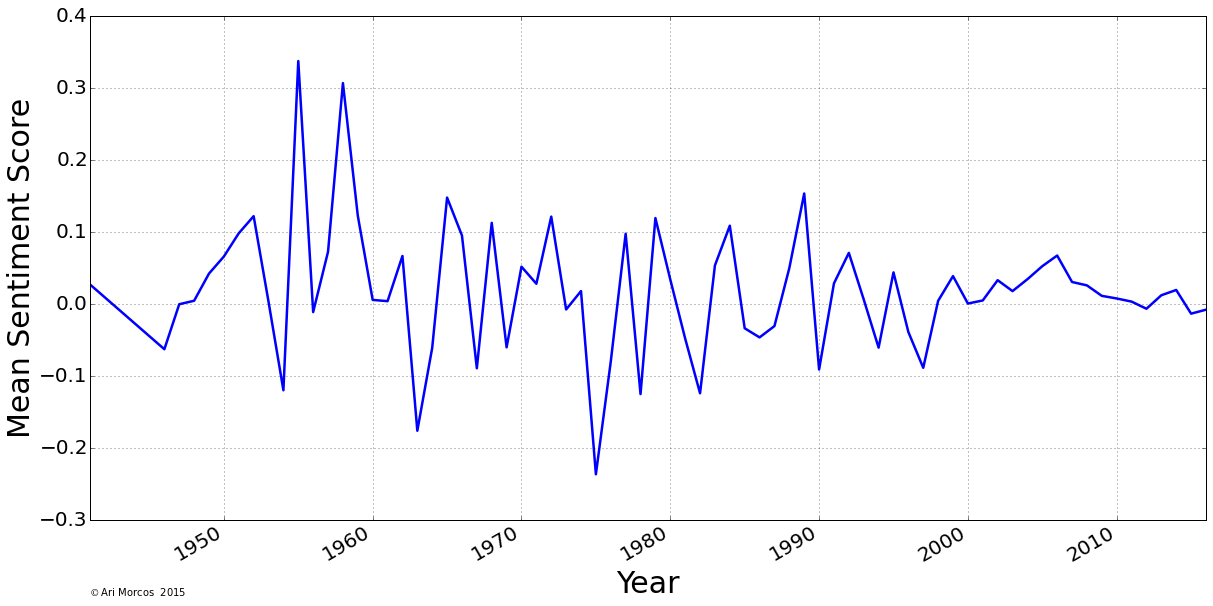

In [18]:
# %matplotlib inline
%pylab inline
x = df.groupby(['year'], as_index=False).agg({'wordCount':'mean', 'score': 'mean'})
ax = x.plot(x='year', y='score', legend=False, figsize=(20,10), fontsize=20, lw=2.5, color='b')
ax.figure.autofmt_xdate();
ax.set_xlabel('Year', fontsize=30);
ax.set_ylabel('Mean Sentiment Score', fontsize=30);
addCopyright(ax, yOffset=-0.1)

In [5]:
def getMeanScore(tempDF):
    """ Calculate mean score for each year """ 
    maxYear = int(tempDF.year.max())
    minYear = int(tempDF.year.min())
    minYear = 1960

    yearList = range(minYear, maxYear)
    avgScore = []
    for year in yearList:
        avgScore.append(np.mean(tempDF[tempDF.year == year]['score']))
    
    return avgScore, yearList

In [6]:
avgScore, yearList = getMeanScore(df)

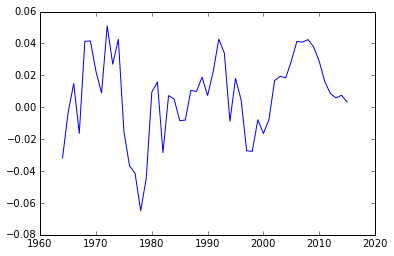

In [7]:
smoothScore = pd.Series(avgScore);
smoothScore = pd.rolling_mean(smoothScore,5)
plt.plot(yearList,smoothScore);

In [8]:
uniqueGenres = df[df.genre.notnull()].genre.unique()
#uniqueGenres = ['Comedy']
genreScores = {}
genreYearLists = {}
for genre in uniqueGenres: 
    genreScores[genre], genreYearLists[genre] = getMeanScore(df[df.genre == genre])

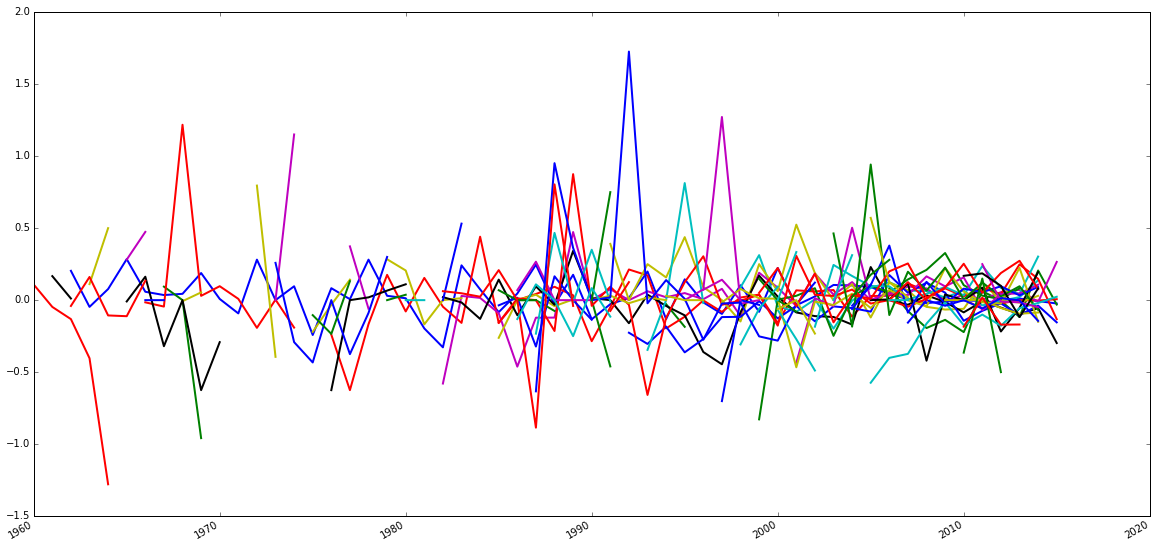

In [9]:
fig = plt.figure(figsize=(20,10))
for genre in uniqueGenres: 
    plt.plot(genreYearLists[genre],genreScores[genre],lw=2)
fig.autofmt_xdate()

In [10]:
meanGenreScores = {}
for genre in uniqueGenres:
    meanGenreScores[genre] = df[df.genre == genre].score.mean()

Populating the interactive namespace from numpy and matplotlib


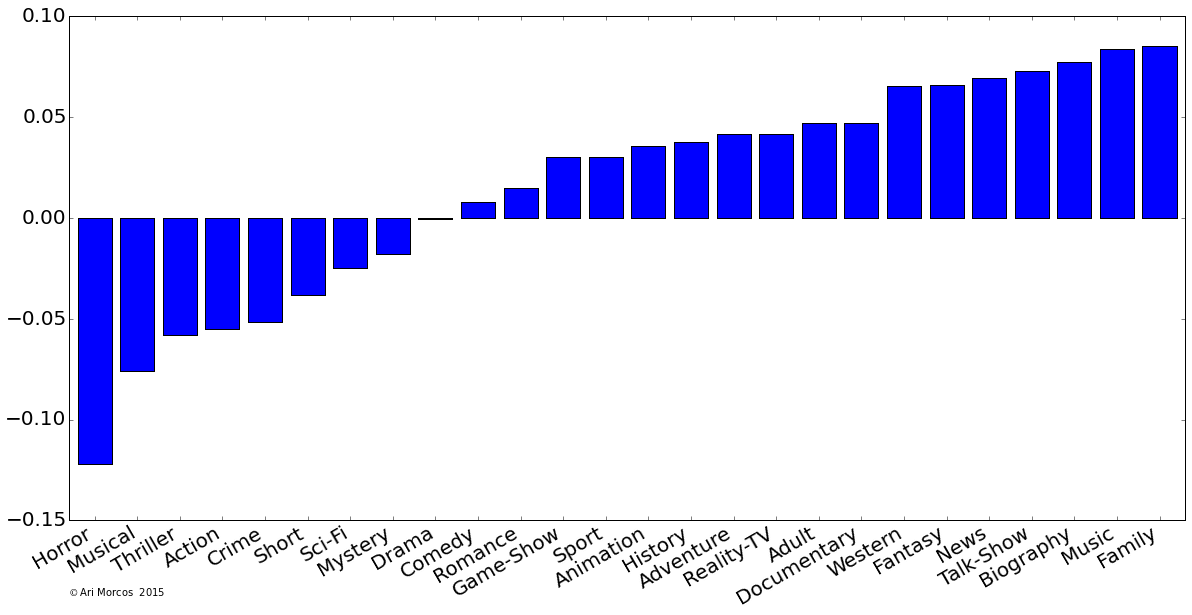

In [17]:
%pylab inline
fig = plt.figure(figsize=(20,10))
plt.bar(range(len(meanGenreScores)), sorted(meanGenreScores.values()), align='center');
plt.xticks(range(len(meanGenreScores)));
ax = plt.gca()
ax.set_xticklabels(sorted(meanGenreScores.keys(), key=meanGenreScores.get));
ax.set_xlim(left=-0.6, right=len(meanGenreScores)-0.4)
fig.autofmt_xdate()
for item in ax.get_xticklabels() + ax.get_yticklabels():
    item.set_fontsize(20)
addCopyright(ax, yOffset=-0.1)

In [16]:
""" Get word distributions """
from nltk.probability import FreqDist

taglineDists = {}
for genre in uniqueGenres:
    # get concatenated taglines word list
    catTags = ' '.join(df[df.genre == genre]['tagline'].values)
    
    # make lowercase 
    catTags = catTags.lower()
    
    #tokenize 
    tagTokens = nltk.wordpunct_tokenize(catTags)
    
    # remove punctation 
    noPunct = [word for word in tagTokens if word.isalpha()]
    
    #create distribution 
    taglineDists[genre] = FreqDist(noPunct)

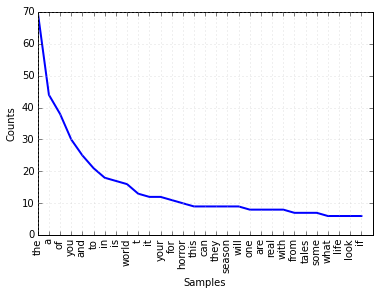

In [74]:
taglineDists['Horror'].plot(30)